In [1]:
from keras.layers import (
    Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation,
    BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D)
from keras.layers.merge import _Merge
from keras.models import Model, Sequential
from keras import backend as K
from keras.optimizers import Adam, RMSprop
from keras.utils import plot_model
from keras.initializers import RandomNormal

import numpy as np
import json
import os
import pickle as pkl
import matplotlib.pyplot as plt

from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Let's train on cars first. Might be more interesting for the case of insurance.
car_label = 1 # Cifar has 1 for automobiles.

train_mask = [y[0] == car_label for y in y_train]
test_mask = [y[0] == car_label for y in y_test]

x_train = x_train[train_mask]
y_train = y_train[train_mask]
x_test = x_test[test_mask]
y_test = y_test[test_mask]

assert x_train.shape[0] == y_train.shape[0] # Number of data points is the same.
assert x_test.shape[0] == y_test.shape[0]

Using TensorFlow backend.


In [2]:
input_dim = x_train.shape[1:]
discriminator_learning_rate = 0.0008
ratio_disc_gen_train = 2

z_dim = 100
batch_size = 128
generator_initial_dense_layer_size = (8,8,64) # Should be the same as the final output of disc?
generator_learning_rate = 0.0004
ratio_gen_disc_train = 1

number_of_epochs = 5000

In [3]:
# Discriminator
discriminator_input = Input(shape = input_dim, name = 'discriminator_input')
x = discriminator_input

x = Conv2D(filters = 64, kernel_size = 5, strides = 2, padding = 'same', 
           name = 'discriminator_conv_0',
           kernel_initializer = 'glorot_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters = 64, kernel_size = 5, strides = 2, padding = 'same',
           name = 'discriminator_conv_1',
           kernel_initializer = 'glorot_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters = 128, kernel_size = 5, strides = 2, padding = 'same',
           name = 'discriminator_conv_2',
           kernel_initializer = 'glorot_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters = 128, kernel_size = 5, strides = 1, padding = 'same',
           name = 'discriminator_conv_3',
           kernel_initializer = 'glorot_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Flatten()(x)
discriminator_output = Dense(1, activation = 'sigmoid', 
                             kernel_initializer = 'glorot_uniform')(x)

discriminator = Model(discriminator_input, discriminator_output)

W1108 05:57:38.528105 140437028030272 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1108 05:57:38.546289 140437028030272 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1108 05:57:38.559674 140437028030272 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1108 05:57:38.573514 140437028030272 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:17

In [4]:
# Generator
generator_input = Input(shape = (z_dim,), name = 'generator_output')
x = generator_input

x = Dense(np.prod(generator_initial_dense_layer_size),
          kernel_initializer = 'glorot_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Reshape(generator_initial_dense_layer_size)(x)

x = UpSampling2D()(x)
x = Conv2D(filters = 128, kernel_size = 5, padding = 'same', strides = 1,
           name = 'generator_conv_0',
           kernel_initializer = 'glorot_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2D(filters = 64, kernel_size = 5, padding = 'same', strides = 1,
           name = 'generator_conv_1',
           kernel_initializer = 'glorot_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2DTranspose(filters = 64, kernel_size = 5, padding = 'same', strides = 1,
                    name = 'generator_conv_2',
                    kernel_initializer = 'glorot_uniform')(x)
x = Activation('relu')(x)

x = Conv2DTranspose(filters = 3, kernel_size = 5, padding = 'same', strides = 1,
                    name = 'generator_conv_3',
                    kernel_initializer = 'glorot_uniform')(x)
x = Activation('tanh')(x) # Last layer used tanh instead of relu

generator_output = x

generator = Model(generator_input, generator_output)

W1108 05:57:39.150700 140437028030272 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2018: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.



In [50]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_output (InputLayer (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              413696    
_________________________________________________________________
batch_normalization_5 (Batch (None, 4096)              16384     
_________________________________________________________________
activation_5 (Activation)    (None, 4096)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 64)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 64)        0         
_________________________________________________________________
generator_conv_0 (Conv2D)    (None, 16, 16, 128)       204928    
__________

In [5]:
# Think there might be something wrong given the shapes are out of whack. Only one way
# to find out - train it and see what happens.

# Discriminator training setup
discriminator.compile(
    optimizer = Adam(lr = discriminator_learning_rate),
    loss = 'binary_crossentropy',
    metrics = ['accuracy'],
)

# Adversarial training setup
discriminator.trainable = False
model_input = Input(shape = (z_dim,), name = 'model_input')
model_output = discriminator(generator(model_input))
adversarial = Model(model_input, model_output)
adversarial.compile(
    optimizer = Adam(lr = generator_learning_rate),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)
discriminator.trainable = True

W1108 05:57:39.406718 140437028030272 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1108 05:57:39.415837 140437028030272 deprecation.py:323] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
d_loss = []
d_acc = []
g_loss = []
g_acc = []

d_loss_real_list = []
d_loss_fake_list = []
d_acc_real_list = []
d_acc_fake_list = []

for i in range(number_of_epochs):
    
    for k in range(ratio_disc_gen_train):
        # First train the discriminator
        valid = np.ones((batch_size,1))
        fake = np.zeros((batch_size,1))

        idx = np.random.randint(0, x_train.shape[0], batch_size) # Get a random bunch of xs.
        true_imgs = x_train[idx]

        noise = np.random.normal(0,1, (batch_size, z_dim))
        gen_imgs = generator.predict(noise)

        # Performance on true images
        d_loss_real, d_acc_real = discriminator.train_on_batch(x = true_imgs, y = valid)

        # Performance on fake images
        d_loss_fake, d_acc_fake = discriminator.train_on_batch(x = gen_imgs, y = fake)

        d_loss.append(0.5 * (d_loss_real + d_loss_fake))
        d_acc.append(0.5 * (d_acc_real + d_acc_fake))
        d_loss_real_list.append(d_loss_real)
        d_loss_fake_list.append(d_loss_fake)
        d_acc_real_list.append(d_acc_real)
        d_acc_fake_list.append(d_acc_fake)

    discriminator.trainable = False
    for j in range(ratio_gen_disc_train):
        # Then now we train the generator
        valid = np.ones((batch_size,1))
        noise = np.random.normal(0,1, (batch_size, z_dim))

        g_loss_tmp, g_acc_tmp = adversarial.train_on_batch(x = noise, y = valid)
    g_loss.append(g_loss_tmp) # Only take the loss after two updates
    g_acc.append(g_acc_tmp) # Take the accuracy after two updates
    # if we don't do this we have two values per discriminator update.
    
    discriminator.trainable = True

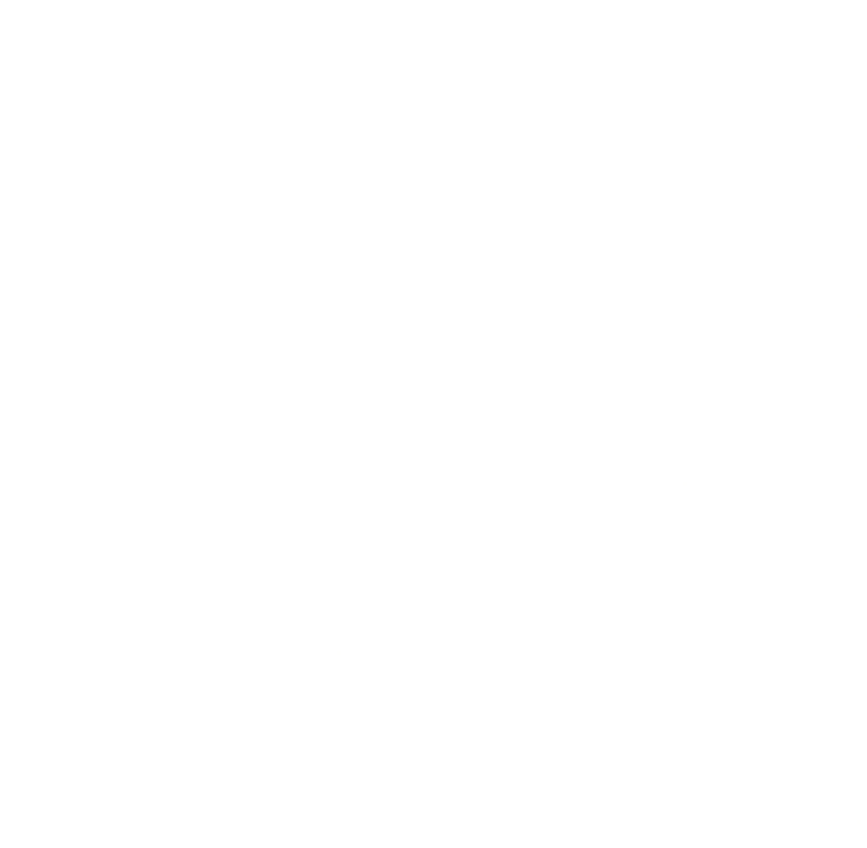

In [37]:
# See how the generator does after 5 rounds of training.
r, c = 5, 5 # Rows and columns
noise = np.random.normal(0,1, (r * c, z_dim))
gen_imgs = generator.predict(noise)

# What are these two lines for?
gen_imgs = 0.5 * (gen_imgs + 1)
gen_imgs = np.clip(gen_imgs, 0, 1)

fig, axs = plt.subplots(r, c, figsize = (15,15))
cnt = 0

for i in range(r):
    for j in range(c):
        axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]))
        axs[i,j].axis('off')
        cnt += 1

Text(0.5, 1.0, 'Generator_loss')

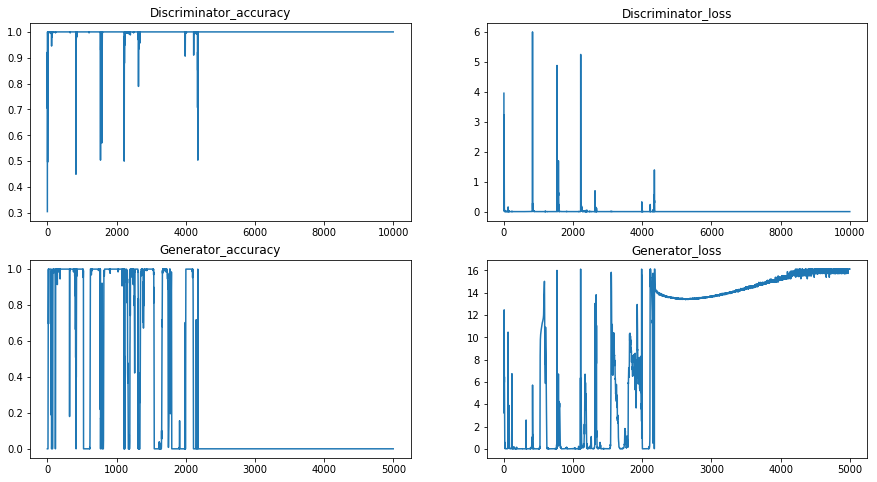

In [16]:
plt.figure(figsize = (15,8))
plt.subplot(221)
plt.plot(d_acc, label = 'disc_acc')
plt.title('Discriminator_accuracy')

plt.subplot(222)
plt.plot(d_loss, label = 'disc_loss')
plt.title('Discriminator_loss')

plt.subplot(223)
plt.plot(g_acc, label = 'gen_acc')
plt.title('Generator_accuracy')

plt.subplot(224)
plt.plot(g_loss, label = 'gen_loss')
plt.title('Generator_loss')

In [ ]:
plt.figure(figsize = (15,8))
plt.subplot(221)
plt.plot(d_acc_fake_list, label = 'disc_acc_fake')
plt.title('Discriminator_accuracy_fake')

plt.subplot(222)
plt.plot(d_loss_fake_list, label = 'disc_loss_fake')
plt.title('Discriminator_loss_fake')

plt.subplot(223)
plt.plot(d_acc_real_list, label = 'disc_acc_real')
plt.title('Discriminator_accuracy_real')

plt.subplot(224)
plt.plot(d_loss_real_list, label = 'disc_loss_real')
plt.title('Discriminator_loss_real')

In [17]:
# Is this mode collapse? We can test on the 25 images that are randomly sampled, I suppose.
discriminator.predict(gen_imgs)

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [18]:
# How can the discriminator actually fail to see what pure white is not a car?
discriminator.predict(x_test[:10,:,:,:])

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

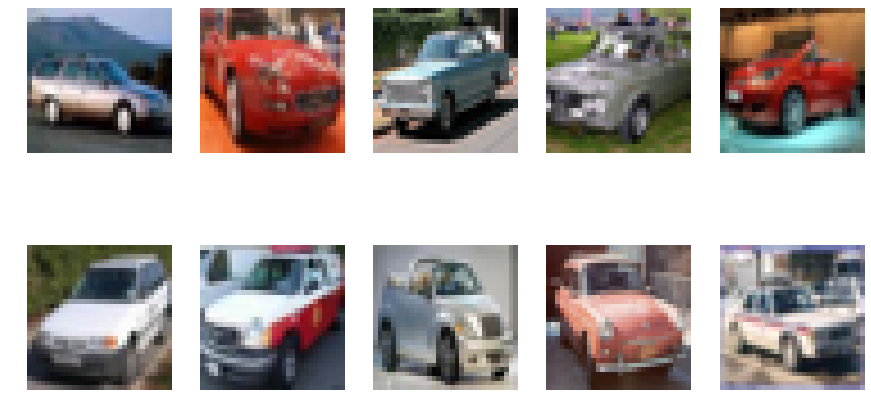

In [19]:
r,c = 2,5
fig, axs = plt.subplots(r, c, figsize = (15,8))
cnt = 0

for i in range(r):
    for j in range(c):
        axs[i,j].imshow(np.squeeze(x_train[cnt, :,:,:]))
        axs[i,j].axis('off')
        cnt += 1

In [ ]:
# Did the gradients disappear?
# Totally confused. It seems like the discriminator has zero loss. Yet, the discriminator 
# is messing up on the generated images.

In [49]:
discriminator.predict(np.ones(shape=(1,32,32,3)))

array([[1.]], dtype=float32)